# 機械学習帳 主成分分析の実装

[機械学習帳の主成分分析(13.5)](https://chokkan.github.io/mlnote/unsupervised/04pca2.html#id12)をなぞった実装を通じて13.4の寄与率、累積寄与率を確認します。

## 講義内容の復習

![chapter13-1.svg](./images/chapter13/chapter13-1.svg)

![chapter13-2.svg](./images/chapter13/chapter13-2.svg)

## 0. セットアップ

日本語を表示するため、`japanize-matplotlib`をインストールします。

In [1]:
!pip install japanize-matplotlib

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/use/literacy/ssdse/)に収録されている都道府県庁所在市別・家計消費データ（SSDSE-C）を読み込みます。

In [3]:
URL = "https://www.nstac.go.jp/sys/files//SSDSE-C-2022.csv"
import urllib
from pathlib import Path


csv = urllib.request.urlopen(URL).read().decode("shift-jis")
csv_path = Path("./data/ssdse-c-2022.csv")
with csv_path.open(mode="w", encoding="utf-8") as f:
    f.write(csv)

In [4]:
import pandas as pd


raw_df = pd.read_csv("./data/ssdse-c-2022.csv")
raw_df.head(5)

,SSDSE-C-2022,Prefecture,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,地域コード,都道府県,市,世帯人員,食料（合計）,01 穀類,米,食パン,他のパン,生うどん・そば,...,すし（外食）,和食,中華食,洋食,焼肉,ハンバーガー,他の主食的外食,喫茶代,飲酒代,学校給食
1,R00000,全国,全国,2.95,960240,79678,22998,10163,21494,3513,...,13620,19716,4179,9794,6184,5067,44164,6522,11358,9713
2,R01100,北海道,札幌市,2.84,942332,82566,29665,9367,18496,3214,...,16906,22845,3772,15761,7132,4187,20326,5462,14817,13273
3,R02201,青森県,青森市,2.87,892205,73320,21932,8285,17063,3164,...,12594,13802,2748,6796,5794,3991,14162,2833,6874,9698
4,R03201,岩手県,盛岡市,3.12,937554,79379,23297,8402,20278,3435,...,11490,9847,1826,5333,4951,3884,35759,4046,11100,10647


In [5]:
code_name = raw_df.iloc[0,:]  # コードの名称記載行を取得
df = raw_df.drop(0, axis=0) # 不要な行の削除
location_name = df.iloc[:,:3]  # 県庁所在地名を取得
location_name.set_index("SSDSE-C-2022", inplace=True)
df = df.drop(["Prefecture", "City"], axis=1) # 不要な列の削除
df = df.set_index("SSDSE-C-2022")  # 県庁所在地のコードをindexにする
df = df.astype("float32")  # 数値型に変換

外食のみで絞ります。

In [6]:
TARGET_CATEGORY = "LB12"

In [7]:
feature_df = df[[c for c in df.columns if c.startswith(TARGET_CATEGORY) and len(c) > len(TARGET_CATEGORY)]]
feature_df.head(5)

,LB121101,LB121102,LB121103,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
SSDSE-C-2022,,,,,,,,,,,,,
R00000,5474.0,6137.0,2094.0,13620.0,19716.0,4179.0,9794.0,6184.0,5067.0,44164.0,6522.0,11358.0,9713.0
R01100,5581.0,6695.0,1630.0,16906.0,22845.0,3772.0,15761.0,7132.0,4187.0,20326.0,5462.0,14817.0,13273.0
R02201,4605.0,9508.0,812.0,12594.0,13802.0,2748.0,6796.0,5794.0,3991.0,14162.0,2833.0,6874.0,9698.0
R03201,5453.0,8551.0,1764.0,11490.0,9847.0,1826.0,5333.0,4951.0,3884.0,35759.0,4046.0,11100.0,10647.0
R04100,6575.0,9333.0,2452.0,12384.0,16022.0,2890.0,7540.0,6073.0,4585.0,35037.0,5097.0,7996.0,9177.0


In [8]:
feature_jp_df = feature_df.rename(
                    columns=dict(zip(feature_df.columns, code_name[feature_df.columns])),
                    index=dict(zip(feature_df.index, location_name["City"][location_name.index == feature_df.index]))
                )

# その他系の項目を除去
feature_jp_df = feature_jp_df[[c for c in feature_jp_df.columns if c not in ("他の主食的外食", "他の麺類外食")]]
feature_jp_df = feature_jp_df[1:]

In [9]:
feature_jp_df.head(5)

,日本そば・うどん,中華そば,すし（外食）,和食,中華食,洋食,焼肉,ハンバーガー,喫茶代,飲酒代,学校給食
SSDSE-C-2022,,,,,,,,,,,
札幌市,5581.0,6695.0,16906.0,22845.0,3772.0,15761.0,7132.0,4187.0,5462.0,14817.0,13273.0
青森市,4605.0,9508.0,12594.0,13802.0,2748.0,6796.0,5794.0,3991.0,2833.0,6874.0,9698.0
盛岡市,5453.0,8551.0,11490.0,9847.0,1826.0,5333.0,4951.0,3884.0,4046.0,11100.0,10647.0
仙台市,6575.0,9333.0,12384.0,16022.0,2890.0,7540.0,6073.0,4585.0,5097.0,7996.0,9177.0
秋田市,5717.0,8927.0,14497.0,14451.0,2541.0,5430.0,7340.0,3014.0,3260.0,10918.0,10276.0


各特徴間の相関を確認します。

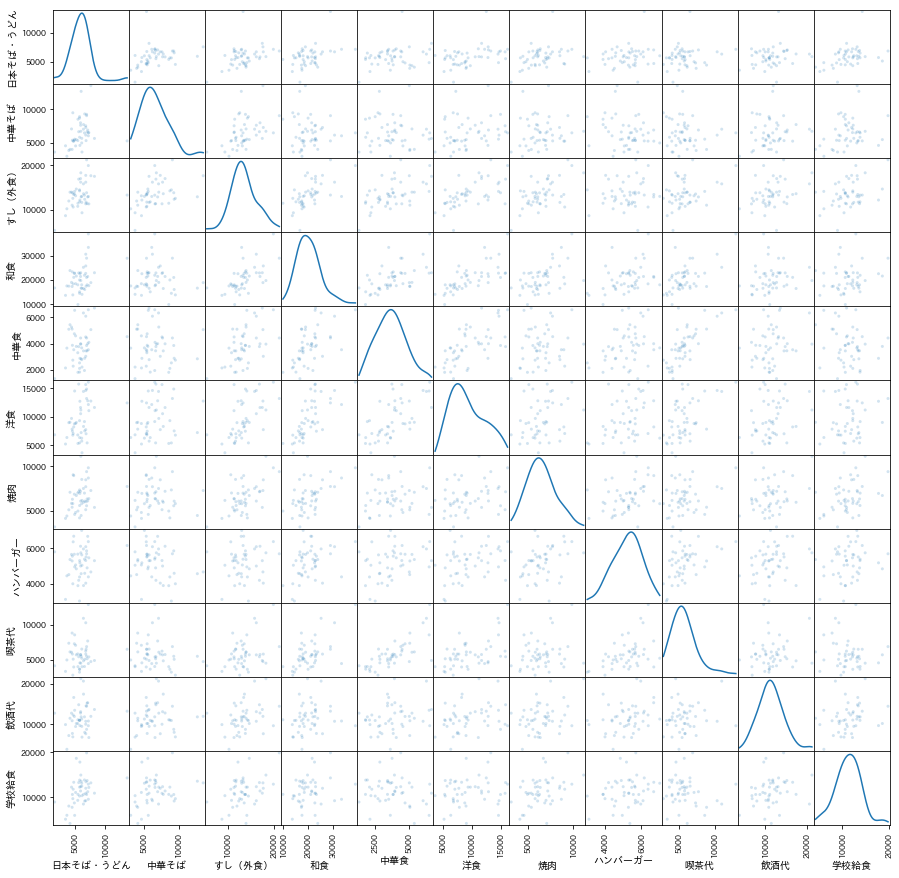

In [10]:
from pandas.plotting import scatter_matrix


scatter_matrix(feature_jp_df, alpha=0.2, figsize=(15, 15), diagonal="kde");

## 1. 主成分分析

`scikit-learn`を用いて主成分分析を実施します。

In [11]:
from sklearn.decomposition import PCA


pca = PCA(n_components=7)
analyzed = pca.fit_transform(feature_jp_df)
analyzed_df = pd.DataFrame(analyzed, columns=[f"PC{i}" for i in range(1, 8)], index=feature_jp_df.index)

各主成分の特徴を調べます。第１主成分は「和食」、第２主成分は「飲酒代」・「学校給食」が主であることがわかります。

<AxesSubplot:>

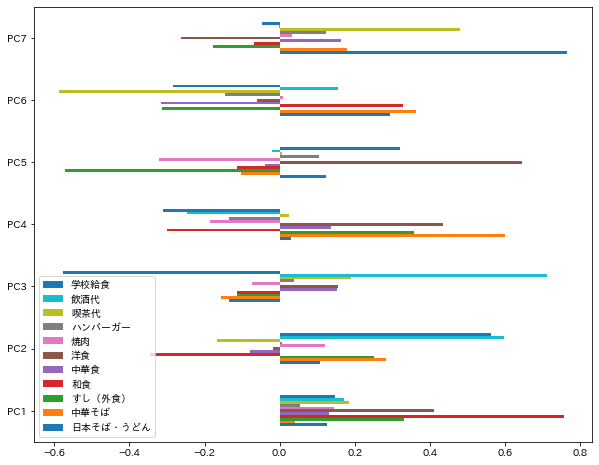

In [12]:
component_df = pd.DataFrame(pca.components_, 
                            columns=feature_jp_df.columns,
                            index=[f"PC{i}" for i in range(1, 8)])

component_df.plot.barh(figsize=(10, 8), legend="reverse")

主成分の寄与率を調べます。第３主成分で90%近く説明できることがわかります。

<AxesSubplot:>

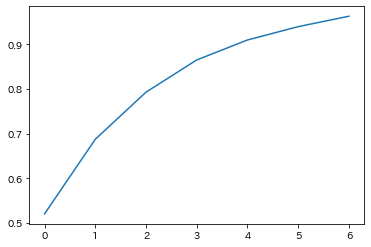

In [13]:
import numpy as np


pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot.line()

第１主成分、第３主成分を使って都道府県庁所在地をプロットします（第２主成分は飲酒台と学校給食が混ざっていて分かりずらかったので）。和食が多いのは岐阜、金沢、飲酒代が多いのは東京、横浜などの首都圏であることがわかります。

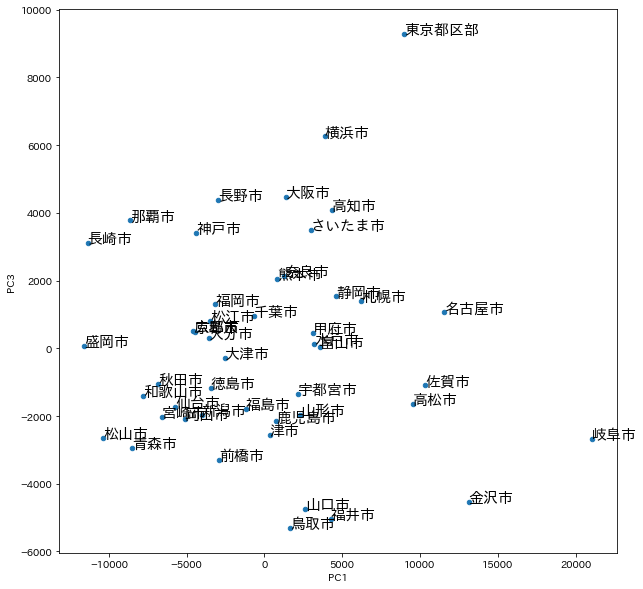

In [14]:
ax = analyzed_df.plot.scatter(x="PC1", y="PC3", figsize=(10, 10))
for index, row in analyzed_df.iterrows():
    ax.annotate(index, xy=(row["PC1"], row["PC3"]), size=15)